# Music Recommendation System #

## Load Packages ##

In [13]:
# process & visualize data 
import numpy as np
import pandas as pd
import itertools
import gc
import seaborn as sns

# split dataset
from sklearn.model_selection import train_test_split

# natural language processing 
from gensim.models import phrases, word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk import word_tokenize
import re

# sparse matrix
import scipy.io
import scipy.sparse

# feature construction
from sklearn.feature_extraction import DictVectorizer

# recommendation system
from lightfm import LightFM

# deployment
from flask import current_app

np.random.seed(0)

## Load Data ##

In [3]:
data_dir = "/home/lee/Documents/DatasetsForGitHub/kaggle_kkbox_music_recommendation_challenge/"

df_train = pd.read_csv(data_dir + "train.csv")
df_songs = pd.read_csv(data_dir + 'songs.csv')
df_members = pd.read_csv(data_dir + 'members.csv')
df_test = pd.read_csv(data_dir + "test.csv")

In [4]:
# download NLP files to working directory
nltk.download(['punkt'], download_dir=data_dir)
nltk.data.path.append(data_dir)

[nltk_data] Downloading package punkt to /home/lee/Documents/DatasetsF
[nltk_data]     orGitHub/kaggle_kkbox_music_recommendation_challenge/.
[nltk_data]     ..
[nltk_data]   Package punkt is already up-to-date!


## Construct Features ##

In [5]:
df_members['registration_date'] = pd.to_datetime(df_members['registration_init_time'], format='%Y%m%d').dt.date
df_members['expiration_date'] = pd.to_datetime(df_members['expiration_date'], format='%Y%m%d').dt.date
df_members.drop(['registration_init_time'], axis=1, inplace=True)

### Impute Missing User Data ###

**Gender**

In [6]:
print("{0:.1f}% members are missing gender information."\
      .format(df_members['gender'].isnull().mean() * 100))

57.8% members are missing gender information.


Assign missing gender to be unknown.

In [7]:
df_members['gender_fill'] = df_members['gender'].fillna('unknown')

**Age**

In [8]:
print("{0:.1f}% members are missing age information.".format((df_members['bd'] == 0).mean() * 100))

57.9% members are missing age information.


Three options here: assign the median of all users with known ages to the users whose ages are unknown, or keep the placeholder 0, or assign a different placeholder other than 0. 

In [9]:
# age_median = df_members[df_members['bd'] != 0]['bd'].median()
# print("Median user age is {}".format(age_median))
# df_members.loc[df_members.bd == 0, 'bd'] = age_median
# del age_median

**Length of membership**

In [10]:
df_members['account_length'] = np.floor((df_members['expiration_date'] 
                                         - df_members['registration_date']).dt.days / 365.25)

### Examine and Impute Item Data ###

**Song length**

Most songs are pop/rock songs and will be in the 3-5 minutes range; longer pieces of music are different types. 

count    2.296320e+06
mean     4.116558e+00
std      2.682000e+00
min      3.083333e-03
25%      3.060000e+00
50%      3.777117e+00
75%      4.621150e+00
max      2.028975e+02
Name: song_length, dtype: float64


/home/lee/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


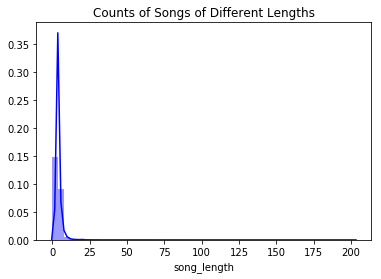

In [17]:
song_length_minutes = df_songs['song_length'] / 60000
print(song_length_minutes.describe())

ax = sns.distplot(song_length_minutes, color='blue')
ax.set_title('Counts of Songs of Different Lengths')
del song_length_minutes

**Genre**

Number of unique genre ids: 191


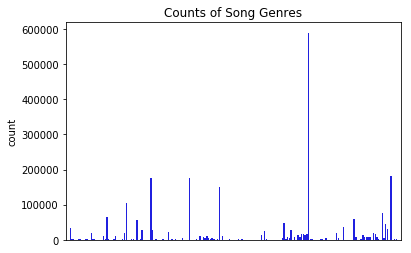

In [17]:
genre_ids_list = [genre_id.split('|') for genre_id in df_songs['genre_ids']\
                  .dropna().tolist()]
# for a pandas column that is 
# '123|456'
# '789'
# '123'
# this returns [['123', '456'], '789', '123']

genre_ids_flatten = list(itertools.chain.from_iterable(genre_ids_list))
# ['123', '456', '789', '123']

print("Number of unique genre ids: {}".format(len(set(genre_ids_flatten))))

ax = sns.countplot(x=genre_ids_flatten, color='blue')
ax.set_title('Counts of Song Genres')
# too many genre ids, do not show x-axis labels 
ax.set(xticks=[])
del genre_ids_flatten, ax

A few genres are far more common than the rest. 

Look at genre ids for the same song. 

In [18]:
genre_id_count = 1 + df_songs['genre_ids'].str.count('\|')
print(genre_id_count.quantile([0.90, 0.95, 0.99]))
del genre_id_count

0.90    1.0
0.95    2.0
0.99    3.0
Name: genre_ids, dtype: float64


Few songs have more than 1 genre id. We arbitrarily extract the first one for the songs with multiple genre ids. Other options include picking the least common genre id and picking the most common one. 

In [19]:
# first fill missing genre id
df_songs['genre_ids'] = df_songs['genre_ids'].fillna('-999')
# extract 1st
df_songs['genre_id_extract'] = df_songs['genre_ids'].apply(lambda row: row.split('|')[0])

**Languages**

In [1]:
print('frequency distribution of language codes:\n{}'.format(df_songs['language'].value_counts()))

NameError: name 'df_songs' is not defined

We deduce that -1.0 represents unknown. Assign -1.0 to records missing language info. 

In [148]:
df_songs['language'] = df_songs['language'].fillna('-1.')

**Artists**

In [20]:
# after manually examining data, frequently used separators between artist names: |, /, \, ;, (, )
artists = [artist.split('[|/\\;\(\)]') for artist in df_songs['artist_name'].dropna().tolist()]
# for a pandas column that is
# 'abc|def'
# 'ghi'
# 'jkl'
# this returns [['abc', 'def'], 'ghi', 'jkl']

artists_flatten = list(itertools.chain.from_iterable(artists))
# ['abc', 'def', 'ghi', 'jkl']

print("Number of unique artists: {}".format(len(set(artists_flatten))))

Number of unique artists: 222363


The artist column occasionally has the same artist's name in multiple languages, for example "周杰倫 (Jay Chou)" is only one person. This case is counted as two artists. 

In [21]:
del artists, artists_flatten